***Step 1: Data Cleaning and Preparation***

In [ ]:
import pandas as pd

# --- 1. Load the Datasets ---
# The main population data has 4 metadata rows at the top that we need to skip.
try:
    population_df = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_1182813.csv', skiprows=4)
    country_meta_df = pd.read_csv('Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_1182813.csv')
    print("✅ Files loaded successfully!")
except FileNotFoundError as e:
    print(f"❌ File not found. Please make sure you've uploaded the files to Colab. Error: {e}")

# --- 2. Merge DataFrames ---
# We merge the population data with the metadata to add 'Region' and 'IncomeGroup'.
merged_df = pd.merge(
    population_df,
    country_meta_df[['Country Code', 'Region', 'IncomeGroup']],
    on='Country Code',
    how='left'
)
print("✅ Data merged successfully!")

# --- 3. Unpivot (Melt) the DataFrame ---
# This transforms the data from a wide format (years in columns) to a long format.
id_vars = ['Country Name', 'Country Code', 'Region', 'IncomeGroup']
# Identify only the columns that represent years
year_columns = [col for col in merged_df.columns if col.isdigit()]

population_long = pd.melt(
    merged_df,
    id_vars=id_vars,
    value_vars=year_columns,
    var_name='Year',
    value_name='Population'
)
print("✅ Data unpivoted successfully!")

# --- 4. Clean the Final DataFrame ---
# Convert columns to the correct data types and drop rows with no population data.
population_long['Year'] = pd.to_numeric(population_long['Year'])
population_long.dropna(subset=['Population'], inplace=True)
population_long['Population'] = population_long['Population'].astype('int64')

# --- 5. Save the Clean Data (Optional, but good practice) ---
# We can save our clean data to a new CSV for easy access later.
population_long.to_csv('population_cleaned.csv', index=False)
print("✅ Data cleaned and saved to 'population_cleaned.csv'")

# --- 6. Display a Preview ---
print("\n--- Preview of Cleaned Data ---")
print(population_long.head())

✅ Files loaded successfully!
✅ Data merged successfully!
✅ Data unpivoted successfully!
✅ Data cleaned and saved to 'population_cleaned.csv'

--- Preview of Cleaned Data ---
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                              Region          IncomeGroup  \
0                          Latin America & Caribbean          High income   
1                                                NaN                  NaN   
2  Middle East, North Africa, Afghanistan & Pakistan           Low income   
3                                                NaN                  NaN   
4                                 Sub-Saharan Africa  Lower middle income   

   Year  Population  
0  1960       54922  
1  1960   130075728  
2  1960     90

***Step 2: Exploratory Analysis and Visualization***


Generating chart: World Population Over Time...


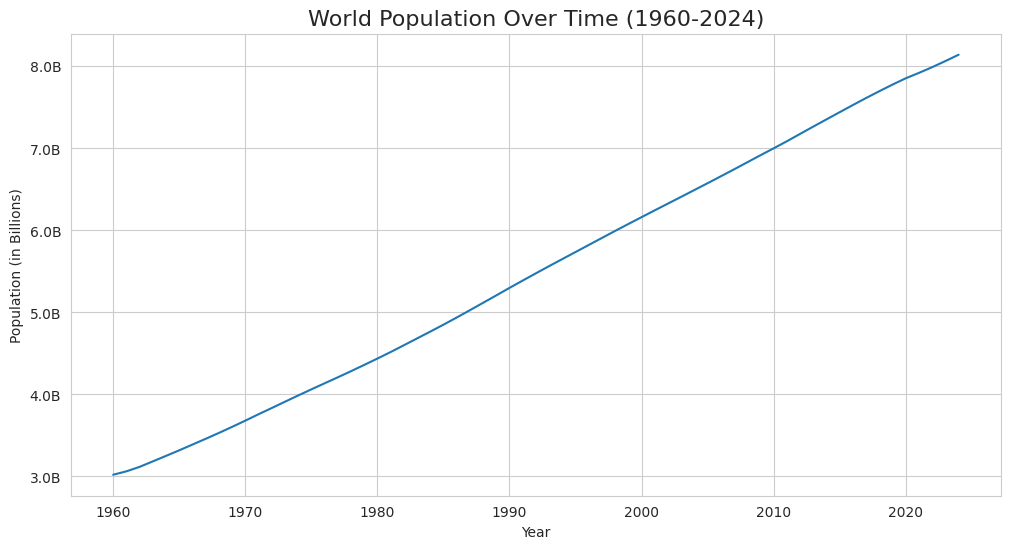


Generating chart: Top 10 Countries for 2024...


/tmp/ipython-input-2396288780.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Population', y='Country Name', data=top_10_countries, palette='viridis')


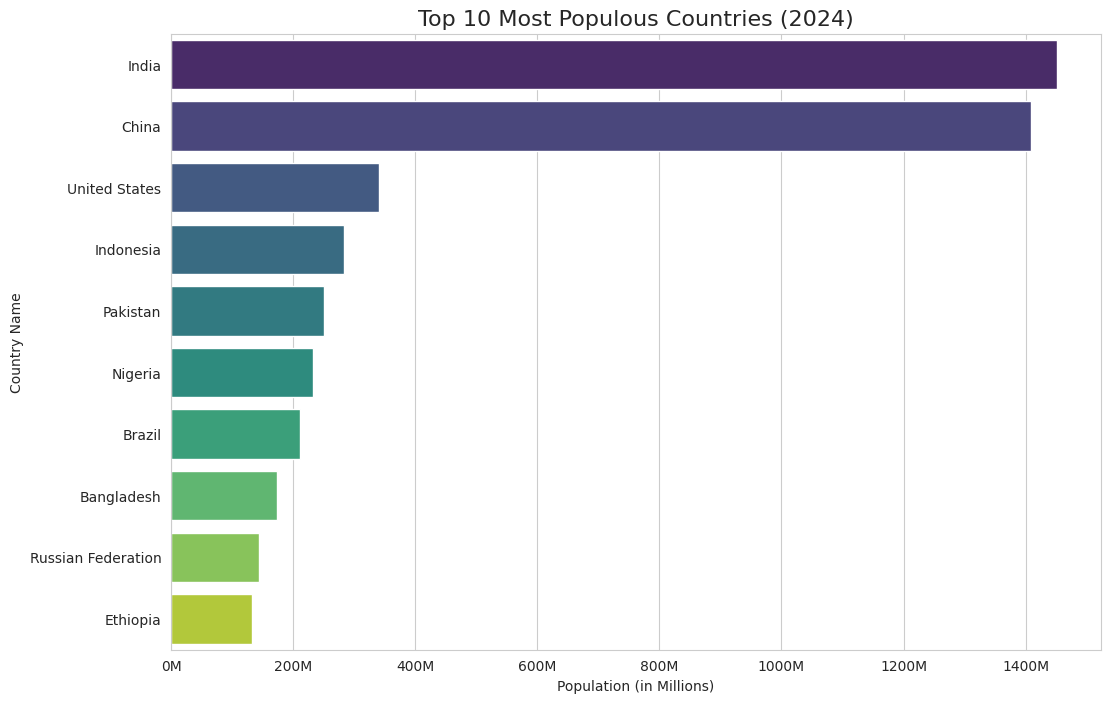

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style("whitegrid")

# --- 1. World Population Over Time (Line Chart) ---
print("\nGenerating chart: World Population Over Time...")
world_pop_trend = population_long[population_long['Country Name'] == 'World']

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Population', data=world_pop_trend)

plt.title('World Population Over Time (1960-2024)', fontsize=16)
plt.ylabel('Population (in Billions)')
# Format the y-axis to be more readable
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
plt.show()


# --- 2. Top 10 Most Populous Countries (Bar Chart) ---
# Let's analyze the most recent year available in the dataset
latest_year = population_long['Year'].max()
print(f"\nGenerating chart: Top 10 Countries for {latest_year}...")

# Filter for the latest year and exclude aggregated regions (where 'Region' is NaN)
df_latest_year = population_long[(population_long['Year'] == latest_year) & (population_long['Region'].notna())]
top_10_countries = df_latest_year.sort_values('Population', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Population', y='Country Name', data=top_10_countries, palette='viridis')

plt.title(f'Top 10 Most Populous Countries ({latest_year})', fontsize=16)
plt.xlabel('Population (in Millions)')
# Format the x-axis to be more readable
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
plt.show()

***Step 3: Create an Interactive Dashboard with Streamlit***

In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
!ngrok authtoken '33cIKIWBgKb4DpopDnVAyLLVuDj_4Xu8doQfY2QXZWs4si87g'

print("✅ Libraries installed and ngrok authenticated!")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
✅ Libraries installed and ngrok authenticated!


In [ ]:
%%writefile dashboard.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Page Configuration ---
st.set_page_config(
    page_title="Global Population Dashboard",
    page_icon="🌍",
    layout="wide"
)

# --- Data Loading ---
# Load the clean data. Add a try-except block for robustness.
@st.cache_data
def load_data():
    try:
        df = pd.read_csv('population_cleaned.csv')
        return df
    except FileNotFoundError:
        st.error("Error: 'population_cleaned.csv' not found. Please run the data cleaning cell first.")
        return None

df = load_data()

if df is not None:
    # --- Dashboard UI ---
    st.title("🌍 Global Population Analysis Dashboard")
    st.markdown("An interactive dashboard to explore world population trends, created in Python.")

    # --- Sidebar Filters ---
    st.sidebar.header("Dashboard Filters")
    selected_year = st.sidebar.slider(
        "Select a Year",
        min_value=int(df['Year'].min()),
        max_value=int(df['Year'].max()),
        value=int(df['Year'].max())
    )

    # --- Main Page Content ---
    df_selected_year = df[df['Year'] == selected_year]
    df_countries = df_selected_year[df_selected_year['Region'].notna()]

    # --- Key Metrics (KPIs) ---
    st.header(f"Global Metrics for {selected_year}")
    col1, col2 = st.columns(2)

    try:
        world_pop = df_selected_year[df_selected_year['Country Name'] == 'World']['Population'].iloc[0]
        col1.metric("Total World Population", f"{world_pop/1e9:.2f} Billion")
    except (IndexError, KeyError):
        col1.metric("Total World Population", "N/A")

    num_countries = df_countries['Country Name'].nunique()
    col2.metric("Number of Countries Analyzed", num_countries)

    # --- Visualizations ---
    st.header("Visualizations")
    fig_col1, fig_col2 = st.columns(2)

    sns.set_style("whitegrid")
    # Plot 1: Top 10 Most Populous Countries
    with fig_col1:
        st.subheader(f'Top 10 Countries')
        top_10 = df_countries.sort_values('Population', ascending=False).head(10)
        fig1, ax1 = plt.subplots(figsize=(8, 8))
        sns.barplot(x='Population', y='Country Name', data=top_10, palette='viridis', ax=ax1)
        ax1.set_xlabel('Population (in Millions)')
        ax1.set_ylabel('')
        ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))
        st.pyplot(fig1)

    # Plot 2: Population by Region
    with fig_col2:
        st.subheader('Population by Region')
        region_pop = df_countries.groupby('Region')['Population'].sum().sort_values(ascending=False)
        fig2, ax2 = plt.subplots(figsize=(8, 8))
        sns.barplot(x=region_pop.values, y=region_pop.index, palette='plasma', ax=ax2)
        ax2.set_xlabel('Total Population (in Billions)')
        ax2.set_ylabel('')
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
        st.pyplot(fig2)

Overwriting dashboard.py


In [ ]:
from pyngrok import ngrok
import webbrowser

# Terminate any existing ngrok tunnels
ngrok.kill()

# Run streamlit in background and open the public URL
!nohup streamlit run dashboard.py --server.port 8501 &

# Open a tunnel to the streamlit port
public_url = ngrok.connect(8501)
print(f"🚀 Your dashboard is live at: {public_url}")

# (Optional) Open the URL in a new tab
# webbrowser.open(public_url)

nohup: appending output to 'nohup.out'
🚀 Your dashboard is live at: NgrokTunnel: "https://froglike-untypically-lavonne.ngrok-free.dev" -> "http://localhost:8501"
